In [1]:
%load_ext autoreload
%autoreload 2

In [109]:
from sys import path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms


import numpy as np
import random
from matplotlib import pyplot as plt
from tqdm import tqdm

In [153]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
PROJECT_PATH = "E:\\Projects\\pytorch_beginner"
path.append(f"{PROJECT_PATH}\\src")
DATA_PATH = f"{PROJECT_PATH}\\data"

In [126]:
class CustomDataset(Dataset):
    """https://pytorch.org/tutorials/beginner/data_loading_tutorial.html"""
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return self.dataset.data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample, y = self.dataset.data[idx], self.dataset.targets[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        return (sample, y)

In [198]:
BATCH_SIZE = 2480
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10

In [182]:
train_data = CIFAR10(root = DATA_PATH, train = True, download = True)
test_data = CIFAR10(root = DATA_PATH, train = False, download = True)
print(f"Type : {type(train_data)}")

# composing multiple transforms into single transform
trfms = transforms.Compose([transforms.ToTensor()])

# to apply transformation on data after loading it
train_data = CustomDataset(dataset = train_data, transform = trfms)
test_data = CustomDataset(dataset = test_data, transform = trfms)

Files already downloaded and verified
Files already downloaded and verified
Type : torchvision.datasets.cifar.CIFAR10


In [183]:
print(f"{len(train_data.dataset.classes)} Classes : {train_data.dataset.classes}")

10 Classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [184]:
img_shape = train_data[0][0].size()
print(f"No. of channels : {img_shape[0]}, img size : {img_shape[1:]}")
print(f"Image shape : {img_shape}")

No. of channels : 3, img size : torch.Size([32, 32])
Image shape : torch.Size([3, 32, 32])


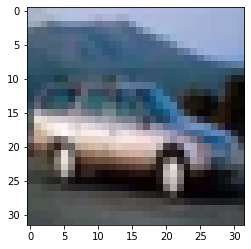

In [185]:
i = 4
# transpose to change image shape from channels * height * width to height * width * channels
plt.imshow(np.transpose(train_data[i][0].numpy(), 
                        axes = (1,2,0))) 

In [193]:
# https://pytorch.org/docs/stable/data.html
# DataLoader supports automatically collating individual fetched
# data samples into batches via arguments batch_size, drop_last, and batch_sampler.
# Dataloader can be used to create fixed size batches of randomly shuffled data. 
# Note: when shuffle is set to True then every time dataloader is initialized, 
# randomly shuffle data is produced. No argument is there to set random state to 
# reproduce same batches of exactly shuffled data.
train_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

$ W_{out} = \frac{W_{in} - F + 2P}{S} + 1 $

$ W_{out} $ is output image width

$ W_{in} $ is input image width

$ F $ is kernel size 

$ P $ is padding

$ S $ is stride 

In [187]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # calling __init__ of nn.Module
    
        # 3 * 32 * 32 -> 6 * 28 * 28 
        self.conv1 = nn.Conv2d(
            in_channels = 3, 
            out_channels = 6,
            kernel_size = (5, 5))
        
        # 6 * 28 * 28 -> 6 * 14 * 14
        self.maxpool = nn.MaxPool2d(kernel_size = (2, 2)) 
        
        # 6 * 14 * 14 -> 12 * 12 * 12 -> 12 * 6 * 6
        self.conv2 = nn.Conv2d(
            in_channels = 6,
            out_channels = 12, 
            kernel_size = (3,3))
        
        # 12 * 6 * 6 -> 256
        self.fc1 = nn.Linear(
            in_features = 12 * 6 * 6, 
            out_features = 256)
        
        # 256 -> 128
        self.fc2 = nn.Linear(
            in_features = 256, 
            out_features = 128)
        
        # final output layer, 10 classes
        # 128 -> 10
        self.fc3 = nn.Linear(
            in_features = 128, 
            out_features = 10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.maxpool(X)
        X = F.relu(self.conv2(X))
        X = self.maxpool(X)
        X = self.flatten(X)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X
        
    def flatten(self, X):
        size = X.size()[1:] # single data size
        size = torch.prod(torch.tensor(size)) # flattening
        return X.view(-1, size)

In [199]:
model = Net()
model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

In [200]:
total_batches = len(train_loader)
t = tqdm(range(NUM_EPOCHS))
for epoch in t:
    epoch_loss = 0.0 # to track loss over all batches
    for i, batch in enumerate(train_loader):
        
        # get the inputs; data is a list of [inputs, labels]
        x, y = batch
        x, y = x.to(device), y.to(device) 

        # zero the parameter gradients
        optimizer.zero_grad()
        
        y_pred = model.forward(x) # forward
        loss = loss_func(y_pred, y) 
        loss.backward() # backward
        optimizer.step() # optimize
        
        epoch_loss += loss.item() # accumulating loss over all batches
        
    t.set_description(f"loss : {epoch_loss : .2f}")

loss :  57.17: 100%|███████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.94s/it]


In [201]:
acc = []
for i, batch in tqdm(enumerate(test_loader)):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model.forward(x)
    y_pred = torch.argmax(y_pred, dim = 1)
    acc.append(torch.sum(y == y_pred))

8it [00:00, 13.41it/s]


In [202]:
np.sum(acc) / (len(test_loader) * BATCH_SIZE)

tensor(0.2337, device='cuda:0')